# Project Inquiries:

1) Is Earth’s average temperature rising over time?

2) Does Earth’s average temperature fluctuate in a predictable pattern?

3) Can we use readings of past Earth temperatures to predict future Earth temperatures?

4) Does taking the Earth’s average temperature over land very significantly from its average temperature taken over land and ocean?

In [1]:
# imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

from fbprophet import Prophet

import wrangle
import explore
import modeling

import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


# Acquire

In [2]:
df = pd.read_csv('GlobalTemperatures.csv')
df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare

•	set data to date time <br>
•	sorted rows by date <br>
•	set date as index <br>
•	created separate dataframes for average land temperature and average land and ocean temperature <br>
•	converted temperature form both dataframes to farenhight <br>
•	removed data prior to ‘1753’ from the land only dataframe to remove nulls <br>
•	removed data prior to '1850' from the land and ocean dataframe to remove nulls <br>

In [3]:
df_land, df_ocean = wrangle.pre_split_prep(df)

### Split Data
•	~80% train <br>
•	~13% validate <br>
•	~7% test <br>
•	data seperated at the end of the nearest year

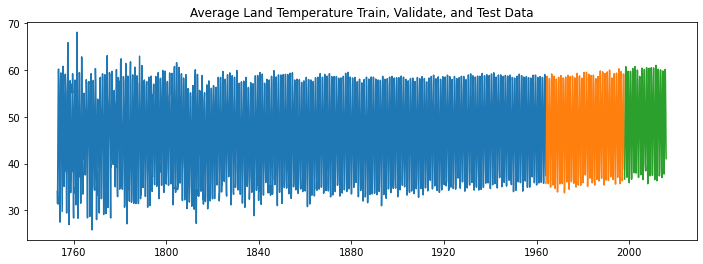

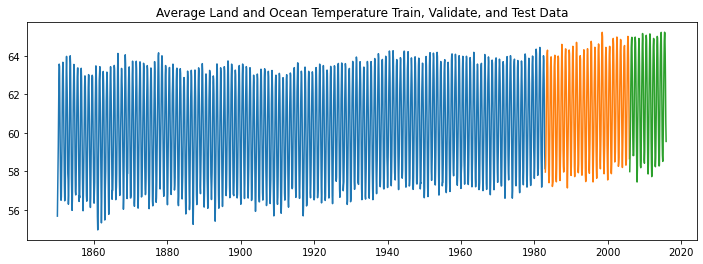

In [4]:
train_land, validate_land, test_land, train_ocean, validate_ocean, test_ocean = wrangle.tvt_split(df_land, df_ocean)

In [5]:
train_ocean

,LandAndOceanAverageTemperature
dt,
1850-01-01,55.666
1850-02-01,57.176
1850-03-01,58.086
1850-04-01,59.334
1850-05-01,61.014
...,...
1982-08-01,63.734
1982-09-01,62.708
1982-10-01,60.986


In [6]:
validate_ocean

,LandAndOceanAverageTemperature
dt,
1983-01-01,57.958
1983-02-01,58.338
1983-03-01,59.366
1983-04-01,60.936
1983-05-01,62.680
...,...
2005-08-01,64.750
2005-09-01,63.806
2005-10-01,62.050


In [7]:
test_ocean

,LandAndOceanAverageTemperature
dt,
2006-01-01,57.980
2006-02-01,58.870
2006-03-01,59.932
2006-04-01,61.458
2006-05-01,62.926
...,...
2015-08-01,65.178
2015-09-01,64.098
2015-10-01,62.580


# Explore

In [8]:
train_land.describe()

,LandAverageTemperature
count,2532.000000
mean,46.421765
std,8.835657
min,25.840000
25%,38.159000
50%,46.860000
75%,54.684500
max,68.042000


### Land Only - Observations

•	Mean: 46 <br>
•	Std: 9 <br>
•	Range: 26 - 68 = 42 <br>

### Explore plot of average land temperatures grouped by month, year, and decade

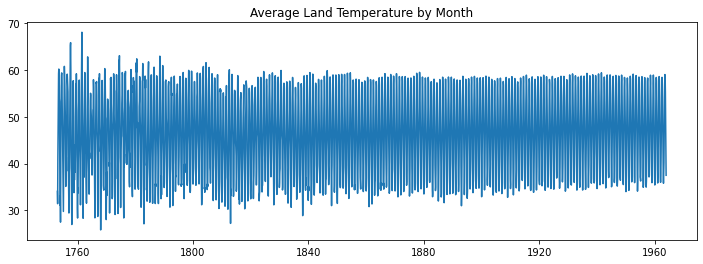

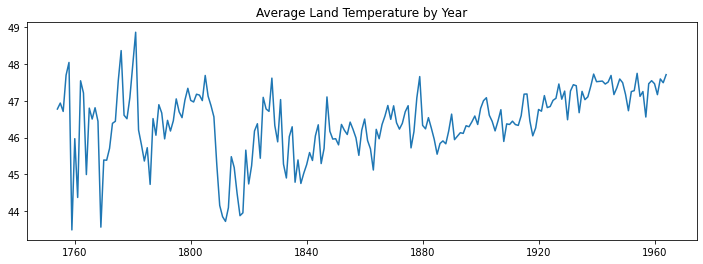

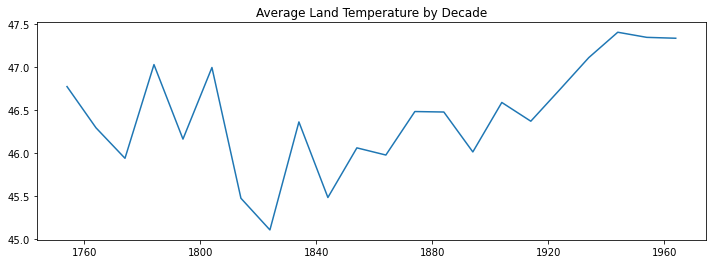

In [9]:
explore.plot_land_exploration(train_land)

### Land Only - Observations

•	The monthly average temperature shows a large variability in temperature towards the beginning of the data, which decreases over time (Possibly the result of innovations in temperature reading technology). <br>

•	The yearly average temperature shows a large variability in temperature towards the beginning of the data, which decreases over time (Possibly the result of innovations in temperature reading technology). <br>

•	It also shows warming trend beginning in the early 1800’s and continuing to the end of the training data. Over this time the yearly average temperature has risen about 3 degrees <br>

•	The by decade average temperature shows a warming trend beginning in the early 1800’s and continuing toward the end of the test data. Over this time the by decade average temperature has risen about 2 degrees <br>

•	Data not sectioned by full decades (first and last data point may be distorted as a result) <br>

### Explore plot of average land and ocean temperatures grouped by month, year, and decade

In [10]:
train_ocean.describe()

,LandAndOceanAverageTemperature
count,1596.000000
mean,60.196054
std,2.517954
min,54.950000
25%,57.828000
50%,60.318000
75%,62.582000
max,64.434000


### Land and Ocean - Observations

•	Mean: 60 <br>
•	Std: 3 <br>
•	Range: 64 - 55 = 42 <br>

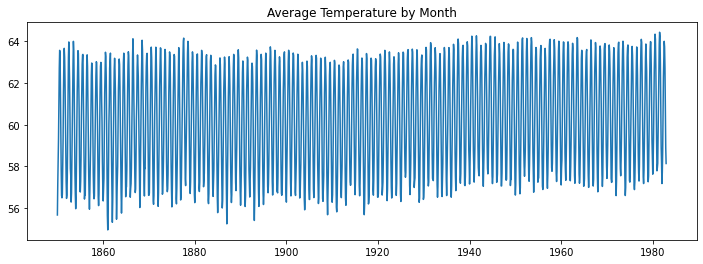

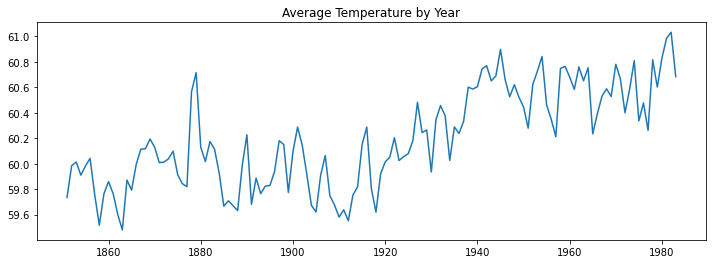

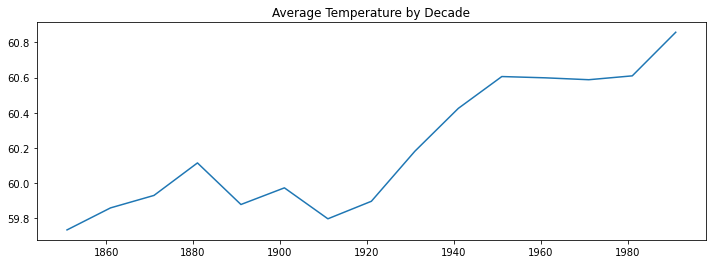

In [11]:
explore.plot_land_ocean_explore(train_ocean)

### Land and Ocean - Observations

•	The monthly average temperature shows a mostly consistent seasonality in average temperature <br>

•	The yearly average temperature shows a warming period from 1910-1940 during this time the by decade average temperature went up by about 1 degree. This was followed by a leveling off period in which the temperature maintained a fairly consistent fluctuation between 60.4 and 60.8 degrees. The temperature reaches its highest toward the end of the graph at about 61 degrees. <br>

•	The by decade average shows a warming trend of one degree across all of the training data.



### Compare plot of average land temperature and average land and ocean temperature

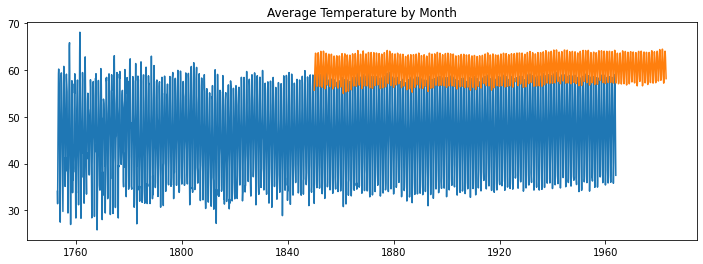

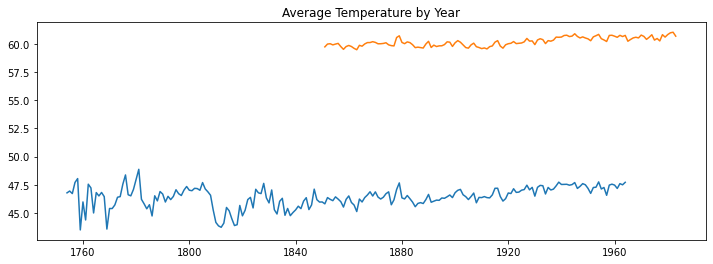

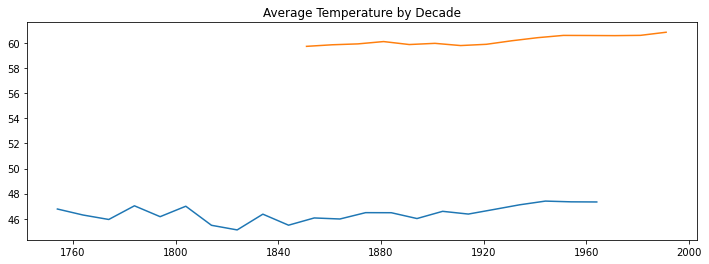

In [12]:
explore.compare_plot(train_land, train_ocean)

### Comparison Observations

•	land only temperature averages cover a much larger range than land and ocean temperature averages <br>

•	They also have higher amount of variability, particularly towards the beginning of the data. The variability smooths out over time and is dramatically lessoned by the time land and ocean temperature averages begin appearing in the data <br>

•	Does less reliable temperature measurements account for the variation in average temperature from 1750 to about the 1840’s? <br>


# Modeling

### Plot a graph of the following for land only temperature averages:
•	last observed value <br>
•	simple average <br>
•	moving average: 1 month, 1 year, 1 decade <br>

### Use the best result as the baseline for modeling

Last Observed Value -- RMSE: 13.1


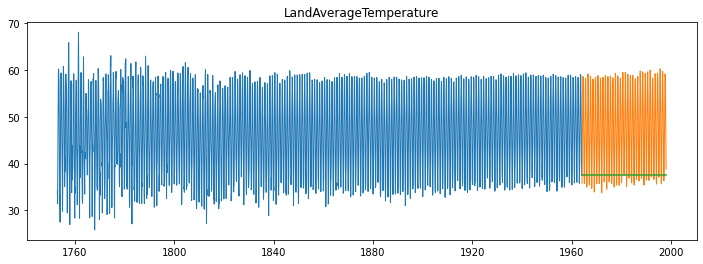

Simple Average -- RMSE: 8.38


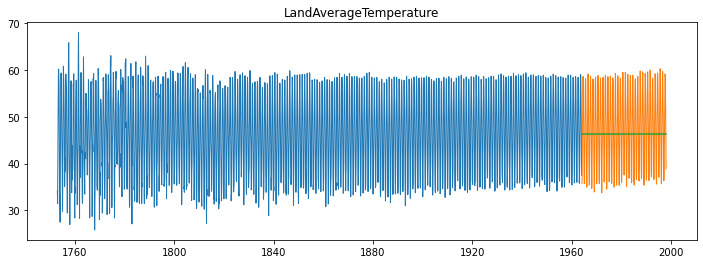

One Month Moving Average  -- RMSE: 13.1


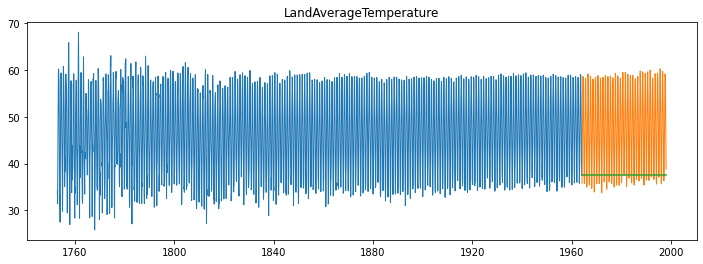

One Year Moving Average  -- RMSE: 8.29


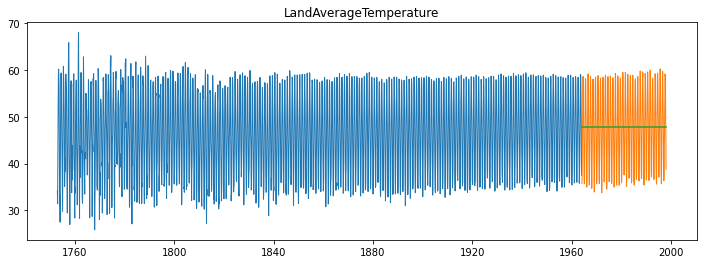

One Decade Moving Average  -- RMSE: 8.3


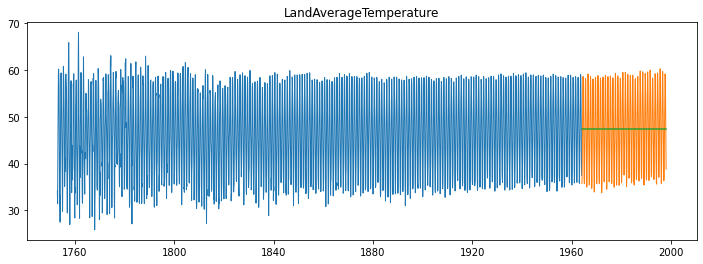

In [13]:
# create comparison dataframes to append prediction results to
eval_df_land = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
df_baseline_land = modeling.get_baseline(train_land, validate_land, 'LandAverageTemperature', eval_df_land)

In [14]:
df_baseline_land

,model_type,target_var,rmse
0,Last Observed Value,LandAverageTemperature,13.10
1,Simple Average,LandAverageTemperature,8.38
2,One Month Moving Average,LandAverageTemperature,13.10
3,One Year Moving Average,LandAverageTemperature,8.29
4,One Decade Moving Average,LandAverageTemperature,8.30


### The best baseline for land only average temperatures is one year moving average with an rmse of 8.29

### Plot a graph of the following for land and ocean temperature averages:
•	last observed value <br>
•	simple average <br>
•	moving average: 1 month, 1 year, 1 decade <br>

### Use the best result as the baseline for modeling

Last Observed Value -- RMSE: 3.91


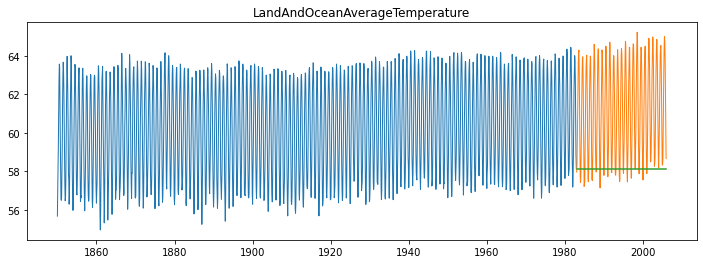

Simple Average -- RMSE: 2.63


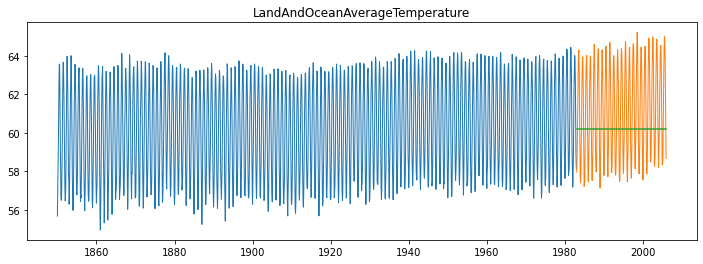

One Month Moving Average  -- RMSE: 3.91


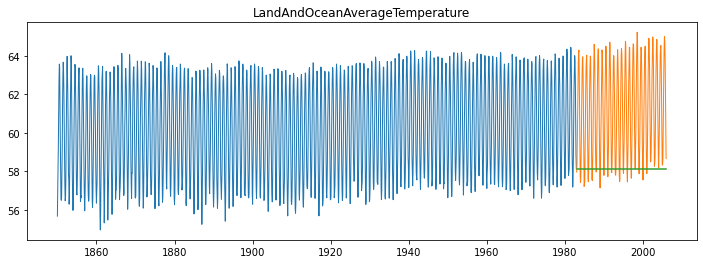

One Year Moving Average  -- RMSE: 2.49


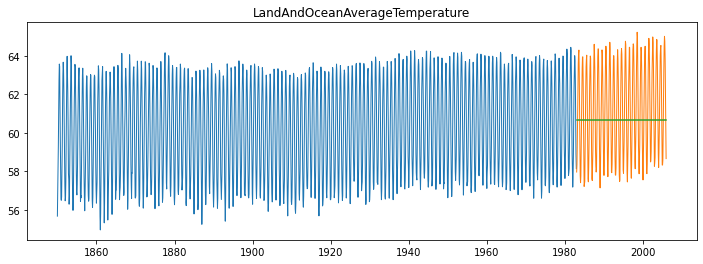

One Decade Moving Average  -- RMSE: 2.49


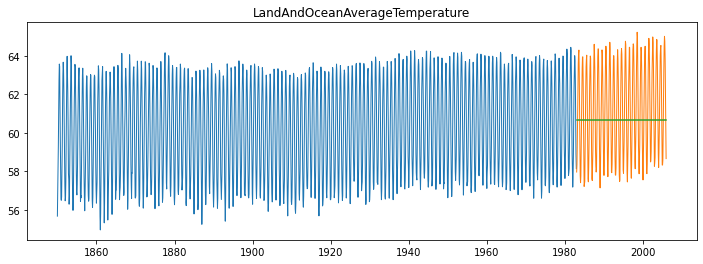

In [15]:
eval_df_ocean = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
df_baseline_ocean = modeling.get_baseline(train_ocean, validate_ocean, 'LandAndOceanAverageTemperature', eval_df_ocean)

In [16]:
df_baseline_ocean

,model_type,target_var,rmse
0,Last Observed Value,LandAndOceanAverageTemperature,3.91
1,Simple Average,LandAndOceanAverageTemperature,2.63
2,One Month Moving Average,LandAndOceanAverageTemperature,3.91
3,One Year Moving Average,LandAndOceanAverageTemperature,2.49
4,One Decade Moving Average,LandAndOceanAverageTemperature,2.49


### The best baseline for land and ocean average temperatures is the one year moving average and one decade moving average, both with an rmse of 2.49

### Make predictions using Holt's Linear Trend
The initial presumptions when using Holt’s linier trend are that the data has a trend and that the data is not seasonal. As the data used in this study is seasonal, I expect to get dubious results from trying to model this data using this method. However, as this project is a learning activity, I have decided to give it a go anyway, as it should provide an excellent case study in why using Holt’s linier trend in this way is ill advised.

Holt's Linear Trend -- RMSE: 15.72


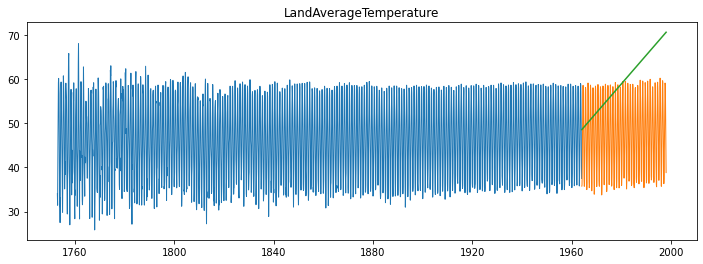

Holt's Linear Trend -- RMSE: 3.2


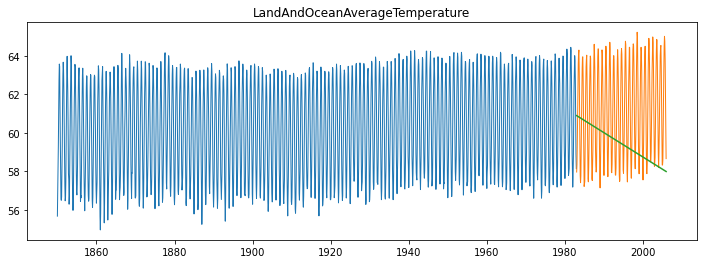

In [17]:
df_holt_land = modeling.holt(train_land, validate_land, "LandAverageTemperature", eval_df_land)
df_holt_ocean =modeling.holt(train_ocean, validate_ocean, "LandAndOceanAverageTemperature", eval_df_ocean)

As predicted Holt’s Linier trend accounted for a trend but not the seasonality of the data. This eventually results in predictions that are outside the range values being observed and only become more extreme the further out in time they are plotted. 

### Make predictions using the Holt-Winter method
The Holt Winter method uses exponential smoothing to account for both the trend and seasonality of the data. I expect better results from this model 

Holt Winter -- RMSE: 0.74


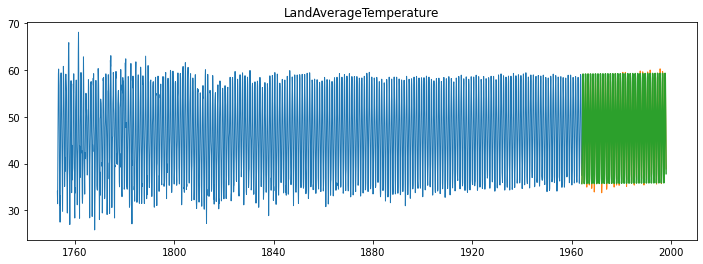

Holt Winter -- RMSE: 0.39


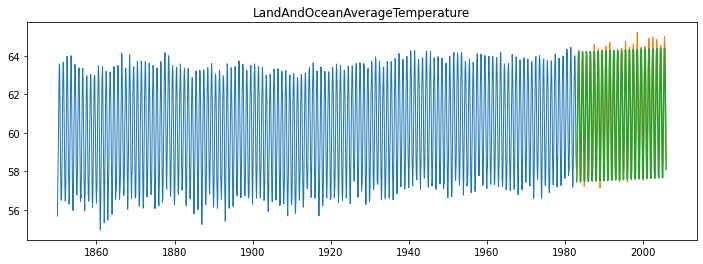

In [18]:
holt_winter_land = modeling.holt_winter(train_land, validate_land, "LandAverageTemperature", eval_df_land)
holt_winter_ocean = modeling.holt_winter(train_ocean, validate_ocean, "LandAndOceanAverageTemperature", eval_df_ocean)

### Both models preformed significantly better than baseline

Land only average temperature had an rmse of 0.7391 <br>
Land and ocean average temperature had an rmse of 0.3875

### Make predictions using Prophet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet -- RMSE: 0.79


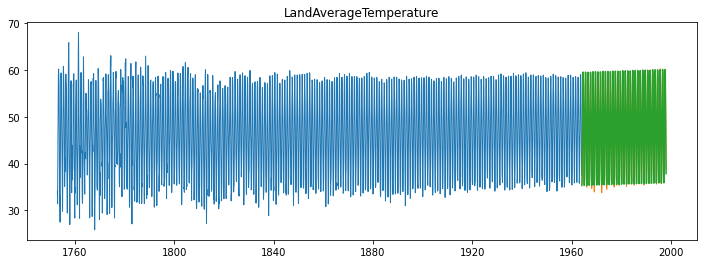

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet -- RMSE: 0.54


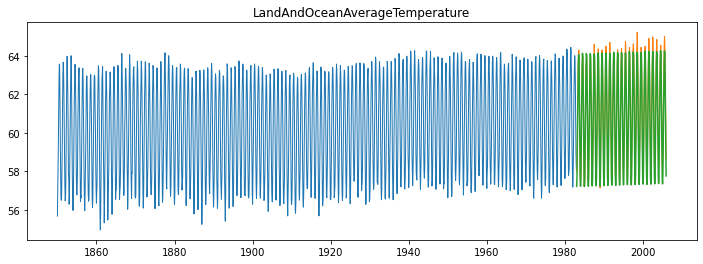

In [19]:
prophet_land = modeling.get_prophet(train_land, validate_land, "LandAverageTemperature", eval_df_land)
prophet_ocean = modeling.get_prophet(train_ocean, validate_ocean, "LandAndOceanAverageTemperature", eval_df_ocean)

### The Prophet model failed to out preform the Holt-Winter model. 
Models predicting average land temperatures and average land and ocean temperatures both produced higher rsme results then their Holt-Winter counterparts. 

### For the final Model we will use the Holt-Winter method to predict test data.

In [20]:
# add validate data to training data
train_land = df_land[:'1997'] 
test_land = df_land['1998':]

train_ocean = df_ocean[:'2005']
test_ocean = df_ocean['2006':]

Holt Winter -- RMSE: 0.87


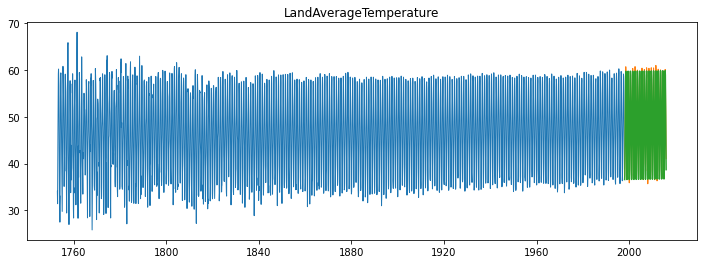

Holt Winter -- RMSE: 0.3


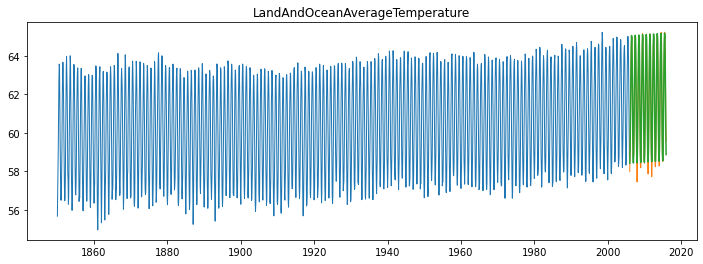

In [21]:
test_land_df = modeling.holt_winter(train_land, test_land, "LandAverageTemperature", eval_df_land)
test_ocean_df = modeling.holt_winter(train_ocean, test_ocean, "LandAndOceanAverageTemperature", eval_df_ocean)

In [23]:
test_land.head(1)

,LandAverageTemperature
dt,
1998-01-01,36.704


In [24]:
test_land.tail(1)

,LandAverageTemperature
dt,
2015-12-01,41.036


# Final Modeling Result
•	The best preforming model was the Holt-Winter model <br>
•	When predicting Earth’s average land temperature on test data, it had a rmse of .87 <br>
•	When predicting Earth’s average land and ocean temperature on test data, it had a rmse of .30 <br>

# Conclutions

**1) Is the Earth’s temperature rising over time?** <br>

•   This is likely, but not certain. <br>

•	Both the Land only and land and ocean average temperature suggest that Earth’s temperature is rising over time, though the small amount of the change leaves open the possibility that this change is due to chance fluctuations. <br>

•	The land only temperature average shows a 2-3 degree warming period between the early 1800’s and today. <br>

•	The land and ocean temperature average shows a 1 degree warming period beginning near 1910 and leveling off near 1940. This leveling off may due to a cooling bias introduced by switching to electronic thermometers in the 1980’s. Additional interference could be due to the moving of several weather stations that occurred in the 1940’s. <br>

**2) Does Earth’s temperature fluctuate in a predictable pattern?** <br>

•	The Earth’s temperature, as measured in this study, fluctuates with fairly consistent annual seasonality  <br>

**3) Can we use readings of past Earth temperatures to predict future Earth temperatures?** <br>

•	Yes, we can. <br>

•	The strongest model I developed for predicting Earth’s average temperature by month uses the Holt Winter method. <br>

•	When predicting Earth’s monthly average land temperature on test data, it had a rmse of .87 <br>

•	When predicting Earth’s monthly average land and ocean temperature on test data, it had a rmse of .30 <br>

•	This means that we can use Earth’s past monthly average temperature readings to predict future monthly averages within less than one degree of error. This is true for both land only and land and ocean measurements. <br>

•	The test dataset contains 17 years of data, so the model’s accuracy may diminish if forecasting out farther than 17 years. <br>

•	Because, there is a lot of noise, in the form of high variability in the land only dataset, I wonder if predictions would be improved by limiting the amount of past data added to the model. <br>

•	Both models show a slight warming trend, this seems to further support the idea that using a more recent dataset would produce better results (lower rmse). <br>

•	Perhaps examining only, the last 100 years of available data would produce better model with lower error. <br>

**4) Does taking the average temperature over land very in pattern, predictability, or variability from temperature taken over land and ocean?** <br>

•	Land only temperature averages are more prone to variability and have a very high level of variability toward the beginning of the data. This variability lessons over time and may reflect unreliable methods of early temperature methods. <br>

•	Land and ocean temperature averages have a much smaller variability and range of values than the land only measurements. This can, in part, be attributed to the fact that this kind of measure was not being taken until 1850, and so it avoids the measure using old and unreliable methods. This is also, in part, due to the fact that Water temperature is more resistant to change than air temperature. <br>

•	Because water temperature is less resistant to change than air temperature the land and ocean temperature is likely to be the best way of measuring global changes in temperature because minor (local) causes of temperature change are less likely to have a dramatic effect on it. <br>

# Data Source

My analysis was performed using the Climate Change: Earth Surface Temperature Data data set obtained from Kaggle at [this](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data) address. 

### According the description the following Complications exist in the dataset 

•	Early data was collected by technicians using mercury thermometers, where any variation in the visit time impacted measurements. <br>
•	In the 1940s, the construction of airports caused many weather stations to be moved. <br>
•	In the 1980s, there was a move to electronic thermometers that are said to have a cooling bias. <br>